# Transition Model 2D Airfoil

This notebook sets up, runs, and post-processes a steady Flow360 simulation of a 2D airfoil with a transition model.

![NLF AIRFOIL](figures/NLF_airfoil.png)

## 1. Create Project from Volume Mesh

We initialize a Flow360 project by uploading an existing CGNS volume mesh, which becomes the `VolumeMesh` for this simulation.

In [1]:
import flow360 as fl
from flow360.examples import NLFAirfoil2D

NLFAirfoil2D.get_files()

project = fl.Project.from_volume_mesh(
    NLFAirfoil2D.mesh_filename, name="Transition Model 2D Airfoil from Python"
)
vm = project.volume_mesh

Output()

Output()

[21:19:25] INFO: VolumeMesh successfully submitted:                                                                
                   type        = Volume Mesh                                                                       
                   name        = Transition Model 2D Airfoil from Python                                           
                   id          = vm-b259b45a-653b-404b-afb4-8195ebbd026f                                           
                   status      = uploaded                                                                          
                   project id  = prj-df6618e1-487a-4f73-8ffd-da7a776b2953                                          
           

Output()

## 2. Operating Conditions and Time Settings

We define the freestream Mach, Reynolds number, temperature, and angle of attack, then choose a steady time-stepping scheme with adaptive CFL for convergence. When using the transition model, more steps are needed to converge the flowfield due to the moving location of the transition location. This is the reason for such high number of steps and the higher `convergence_limiting_factor` of 0.4 which allows faster convergence while still using the adaptive CFL settings.

In [2]:
operating_condition = fl.AerospaceCondition.from_mach_reynolds(
    mach=0.1,
    reynolds_mesh_unit=4e6,
    project_length_unit=project.length_unit,
    temperature=540.0 * fl.u.R,
    alpha=0.0 * fl.u.deg,
)

time_stepping = fl.Steady(
    max_steps=20000, CFL=fl.AdaptiveCFL(convergence_limiting_factor=0.4)
)

[21:19:47] INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

## 3. Transition Model

We configure the transition model solver, choosing linear solver iterations, tight tolerances, and the critical amplification factor `N_crit` that controls transition onset.
The Jacobian and equation evaluation frequencies control how often these operators are rebuilt, balancing robustness against computational cost.

In [3]:
transition_model_solver = fl.TransitionModelSolver(
    linear_solver=fl.LinearSolver(max_iterations=30),
    absolute_tolerance=1e-10,
    N_crit=7.2,
    update_jacobian_frequency=1,
    equation_evaluation_frequency=1,
)

## 4. Outputs

We request surface and slice outputs so that Flow360 saves pressure, skin-friction, y-plus, and related fields needed for later analysis around the airfoil.

In [4]:
outputs = [
    fl.SurfaceOutput(
        surfaces=vm["Block/Aerofoil"],
        output_format="both",
        output_fields=["Cp", "Cf", "yPlus", "CfVec"],
    ),
    fl.SurfaceSliceOutput(
        name="surface_slices",
        entities=[fl.Slice(name="y", normal=(0, 1, 0), origin=(0, -0.5, 0) * fl.u.m)],
        target_surfaces=vm["Block/Aerofoil"],
        output_format="paraview",
        output_fields=["Cp", "Cf", "yPlus", "CfVec"],
    ),
]

## 5. Define `SimulationParams`

We assemble operating conditions, time stepping, boundary condition models, solvers, and outputs into a single `SimulationParams` object used to run the case.

In [5]:
with fl.SI_unit_system:

    params = fl.SimulationParams(
        operating_condition=operating_condition,
        time_stepping=time_stepping,
        models=[
            fl.Wall(
                surfaces=vm["Block/Aerofoil"],
            ),
            fl.Freestream(
                surfaces=vm["Block/Farfield"],
            ),
            fl.SlipWall(entities=[vm["Block/Symmetry"]]),
            fl.Fluid(
                turbulence_model_solver=fl.SpalartAllmaras(
                    absolute_tolerance=1e-10,
                    linear_solver=fl.LinearSolver(max_iterations=30),
                    update_jacobian_frequency=1,
                    equation_evaluation_frequency=1,
                ),
                navier_stokes_solver=fl.NavierStokesSolver(
                    linear_solver=fl.LinearSolver(max_iterations=50),
                    absolute_tolerance=1e-12,
                    update_jacobian_frequency=4,
                    equation_evaluation_frequency=1,
                ),
                transition_model_solver=transition_model_solver,
            ),
        ],
        outputs=outputs,
    )

           INFO: using: SI unit system for unit inference.

## 6. Run Case

We submit the configured simulation to Flow360, creating a case on the server that runs using the project, parameters, and models defined above.

In [6]:
case = project.run_case(params=params, name="Transition Model 2D Airfoil from Python")

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

           INFO: using: SI unit system for unit inference.

[21:19:49] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Transition Model 2D Airfoil from Python                                           
                   id          = case-11767f48-bb81-412f-aec0-70494c03fd78                                         
                   status      = pending                                                                           
                   project id  = prj-df6618e1-487a-4f73-8ffd-da7a776b2953                                          
           

## 7. Post Processing

After the case finishes, we download surface data, compute integrated forces, inspect residual histories, and visualize the friction coefficient distribution over the airfoil.

Notice that the drag coefficient reaches a pseudo step where it increases again due to more length modelled as turbulent boundary layer. Maybe it wwould be good to run even longer for full convergence but for the sake of this example it is not needed. Finally, from the surface slices, we can plot the friction coefficient. We observe the transition locations both at the pressure and suction sides where the friction coefficient increases significnatly.

Output()

Output()

[21:33:46] INFO: Saved to /tmp/tmpx7ap3xst/9a2f753c-4dae-4e33-889e-c77f87b39ba2.csv

Output()

[21:33:48] INFO: Saved to /tmp/tmpx7ap3xst/5d294f90-0649-4a93-ba55-74a682e44972.csv

Output()

[21:33:50] INFO: Saved to /tmp/tmpkjcvuse8/case_data/surfaces.tar.gz

Text(0, 0.5, 'Friction Coefficient')

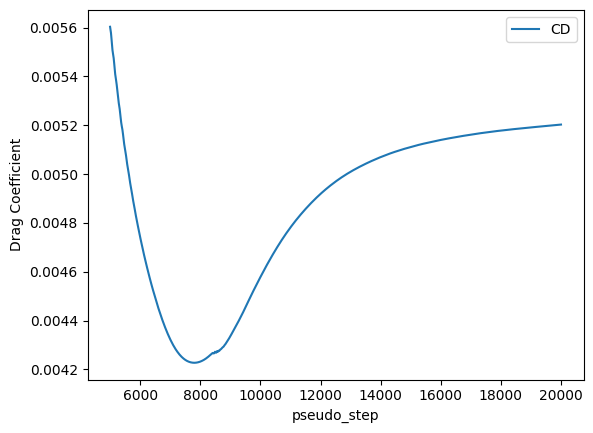

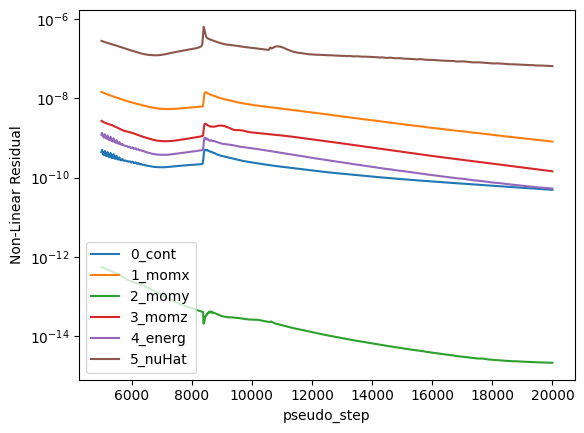

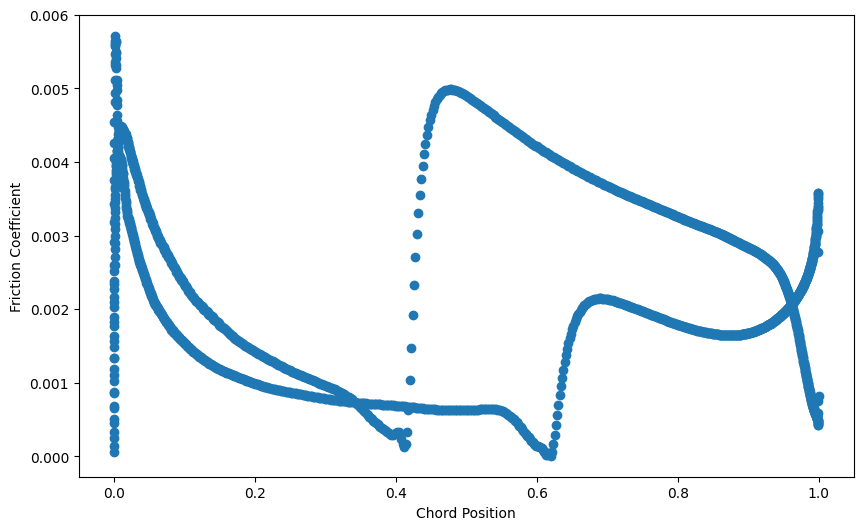

In [7]:
import tempfile
import os
import tarfile
import pyvista as pv
import matplotlib.pyplot as plt


def extract_results(results):
    with tempfile.TemporaryDirectory() as temp_dir:
        destination = os.path.join(temp_dir, "case_data")
        os.makedirs(destination, exist_ok=True)

        results.download(
            surface=True,
            destination=destination,
        )

        surfaces_path = os.path.join(destination, "surfaces.tar.gz")
        with tarfile.open(surfaces_path) as tar:
            tar.extractall(path=temp_dir)  # extract directly into temp_dir

        mesh_path = os.path.join(temp_dir, "surface_slice_y.pvtu")
        mesh = pv.read(mesh_path)

        x = mesh.points[:, 0]
        y = mesh.points[:, 1]
        z = mesh.points[:, 2]
        cf = mesh.point_data["Cf"]
        cp = mesh.point_data["Cp"]

        # Sort based on x-direction
        sorted_indices = x.argsort()
        x = x[sorted_indices]
        y = y[sorted_indices]
        z = z[sorted_indices]
        cf = cf[sorted_indices]
        cp = cp[sorted_indices]

        return x, y, z, cf, cp


case.wait()
results = case.results

total_forces = results.total_forces.as_dataframe()
total_forces_filtered = total_forces[total_forces["pseudo_step"] >= 5000]
total_forces_filtered.plot("pseudo_step", ["CD"])
plt.ylabel("Drag Coefficient")

non_linear = results.nonlinear_residuals.as_dataframe()
non_linear_filtered = non_linear[non_linear["pseudo_step"] >= 5000]
non_linear_filtered.plot(
    "pseudo_step",
    ["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    logy=True,
)
plt.ylabel("Non-Linear Residual")

# Plot friction coefficient
x, y, z, cf, cp = extract_results(results)

plt.figure(figsize=(10, 6))
plt.scatter(x, cf, label="Friction Coefficient")
plt.xlabel("Chord Position")
plt.ylabel("Friction Coefficient")